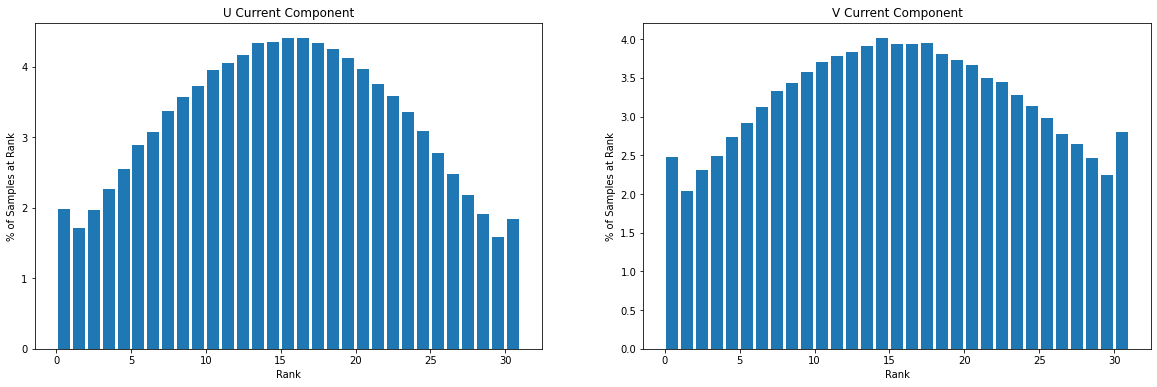

In [69]:
from ocean_navigation_simulator.generative_error_model.models.OceanCurrentNoiseField import OceanCurrentNoiseField
import matplotlib.pyplot as plt
import ensverif as e
import pandas as pd
import numpy as np
import datetime
import os

# load Fc errors
data_dir = "../../../data/drifter_data/dataset_forecast_error/area1_edited"
files = sorted(os.listdir(data_dir))
df = pd.DataFrame()
for file in files:
    df = pd.concat([df, pd.read_csv(os.path.join(data_dir, file))], ignore_index=True)
error = df.dropna()

# get noise
noise_config = "../../../data/drifter_data/variogram_params/tuned_2d_forecast_variogram_area1_edited2.npy"
noise_source = OceanCurrentNoiseField.load_config_from_file(noise_config)
rng = np.random.default_rng(231)

# a day long error
lon_interval = [-140, -120]
lat_interval = [20, 30]
time_interval = [datetime.datetime(2022, 5, 1), datetime.datetime(2022, 5, 2)]

rank_histograms = []
for current_comp in ["u", "v"]:
    errors = error[f"{current_comp}_error"]
    num_ensembles = 30
    obs = None
    size_day = (20*12+1)*(10*12+1)*25
    ensemble = np.zeros((len(errors), num_ensembles))
    for i in range(num_ensembles):
        noise_source.reset(rng)
        noise = noise_source.get_noise_from_ranges(lon_interval, lat_interval, time_interval)
        ensemble[:, i] = noise[f"water_{current_comp}"].values.flatten()[np.random.choice(size_day, len(errors))]

    rel_freq, bins = e.rankhist(ensemble, errors)
    rank_histograms.append([rel_freq, bins])

name_dict = {0: "U", 1: "V"}
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for i, ax in enumerate(axs):
    bins = rank_histograms[i][1]
    rel_freq = rank_histograms[i][0]
    ax.bar(bins[1:len(bins)], rel_freq*100)
    ax.set_ylabel("% of Samples at Rank")
    ax.set_xlabel("Rank")
    ax.title.set_text(f"{name_dict[i]} Current Component")